# Effect of straylight correction on MRS RSRF
We apply the straylight correction (v2) to the MRS FM MTS extended source observations. We then compare the MRS responses derived from said observations (with and without straylight correction).

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
# import modules
import funcs
import mrsobs

import numpy as np
from astropy.io import fits
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
# plt.style.use('presentation')
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

In [3]:
bands = ["1A", "1B", "1C", "2A", "2B", "2C", "3A", "3B", "3C", "4A", "4B", "4C"]

In [4]:
# Define paths to data
workDir       = '/Users/ioannisa/Desktop/python/miri_devel/'
cdpDir        = workDir+'cdp_data/'
d2cMapDir     = workDir+'distortionMaps/'
MTSDir        = workDir+'MRSFluxCal/MIRI_CDP6MRSFluxCal/MtsIrradiance/'
lvl2path      = workDir+'FM_data/LVL2/'

# Populate dictionaries with the wavelength, pixel size and validity maps 
# (corresponding to the detector plane)

sliceMap  = {}
sizeMap   = {}
validMap  = {}
lambdaMap = {}

for band in bands:
    print "Band {}".format(band)
    d2cMaps         = funcs.load_obj('d2cMaps_band{}'.format(band),path=d2cMapDir)
    sliceMap[band]  = d2cMaps['sliceMap']
    lambdaMap[band] = d2cMaps['lambdaMap']
    sizeMap[band]   = funcs.get_pixel_spatial_area(band=band,d2cMaps=d2cMaps)
    
    # create a "valid" map with all the pixels inside the slices of a particular band
    channel = int(band[0])
    # slice numbers in the slice map of the distortion CDP for this band
    sliceInventory = np.unique(sliceMap[band])
    slicesInBand = sliceInventory[np.where( (sliceInventory >= 100*channel ) & (sliceInventory <100*(channel+1)))]
    
    validMap[band] = np.zeros(sliceMap[band].shape)
    for ss in slicesInBand:
        s = int(ss - 100*channel)
        # construct a list of y,x coordinates of detector pixels belonging to slices of this band
        pixels = np.where(sliceMap[band] == ss)
        validMap[band][pixels] = 1

Band 1A
Band 1B
Band 1C
Band 2A
Band 2B
Band 2C
Band 3A
Band 3B
Band 3C
Band 4A
Band 4B
Band 4C


In [5]:
# Populate dictionaries with maps of L_sky
L_skyMap = {}
for BBTemp in ["400K", "600K", "800K"]:
    print "BBTemp {}".format(BBTemp)
    L_skyMap[BBTemp] = {}   
    tabLSky = fits.open(MTSDir+ "MTSEquivalentLsky" + BBTemp + ".fits" )[1]
    ip_Lsky = interp1d(tabLSky.data["wave"], tabLSky.data["L_sky"], kind='cubic')
    for band in ["1A", "1B", "1C", "2A", "2B", "2C", "3A", "3B", "3C", "4A", "4B", "4C"]:
        L_skyMap[BBTemp][band] = np.full( validMap[band].shape, np.nan )
        sel = (validMap[band]==1)
        waves = np.reshape(lambdaMap[band][sel], -1)
        L_skyMap[BBTemp][band][sel] = ip_Lsky(waves)*1000. #mJy/arcsec^2

BBTemp 400K
BBTemp 600K
BBTemp 800K


In [6]:
# Populate dictionaries with maps of E_pix
# Calculate the spectral irradiance E_pix : [mJy/pixel]
# E_pix = omega_pix * L_pix
E_pixMap = {}
for BBTemp in ["400K", "600K", "800K"]:
    print "BBTemp {}".format(BBTemp)
    E_pixMap[BBTemp] = {}   
    for band in ["1A", "1B", "1C", "2A", "2B", "2C", "3A", "3B", "3C", "4A", "4B", "4C"]:
        E_pixMap[BBTemp][band] = np.full( validMap[band].shape, np.nan )
        sel = (validMap[band]==1)
        E_pixMap[BBTemp][band][sel] = sizeMap[band][sel] * L_skyMap[BBTemp][band][sel]

BBTemp 400K
BBTemp 600K
BBTemp 800K


In [6]:
# Populate dictionaries with maps of S_pix [DN/sec] and dS_pix (the error)
# S_pix is the average slope of the BB measurement with the average slope of the
# background measurement subtracted.
# We also populate the Bad pixel map (0 = ok, 1 = do not use)

# -- Uncomment to load already saved maps
# S_pixMap = funcs.load_obj('S_pixMap',path='')
# S_pixMap_STRCORR = funcs.load_obj('S_pixMap_STRCORR',path='')
# dS_pixMap = funcs.load_obj('dS_pixMap',path='')
# BadPixelMap = funcs.load_obj('BadPixelMap',path='')

# -- Uncomment to re-run
S_pixMap,S_pixMap_STRCORR = {},{}
dS_pixMap = {}
BadPixelMap ={}
for BBTemp in ["400K","600K", "800K"]:
    print "BBTemp {}".format(BBTemp)
    S_pixMap[BBTemp] = {}
    S_pixMap_STRCORR[BBTemp] = {}
    dS_pixMap[BBTemp] = {}
    BadPixelMap[BBTemp] = {}
    for band in ["1A", "1B", "1C", "2A", "2B", "2C", "3A", "3B", "3C", "4A", "4B", "4C"]:
        print "Band {}".format(band)
        S_pixMap[BBTemp][band] = np.full( validMap[band].shape, np.nan )
        S_pixMap_STRCORR[BBTemp][band] = np.full( validMap[band].shape, np.nan )
        dS_pixMap[BBTemp][band] = np.full( validMap[band].shape, np.nan )
        BadPixelMap[BBTemp][band] = np.full( validMap[band].shape, 0 )
        hdulist = fits.open(mrsobs.FM_MTS_BB_extended_source(lvl2path,band,bb_temp=BBTemp,output='filename')[0])
        slopeHOLE = hdulist[0].data[0,:,:]
        slopeHOLE_STRCORR = funcs.straylightCorrection(slopeHOLE,sliceMap=sliceMap[band])
        dslopeHOLE = hdulist[0].data[1,:,:]
        maskHOLE = hdulist[0].data[2,:,:]
        hdulist = fits.open(mrsobs.FM_MTS_BB_extended_source(lvl2path,band,bb_temp=BBTemp,output='filename')[1])
        slopeBLANK = hdulist[0].data[0,:,:]
        slopeBLANK_STRCORR = funcs.straylightCorrection(slopeBLANK,sliceMap=sliceMap[band])
        dslopeBLANK = hdulist[0].data[1,:,:]
        maskBLANK = hdulist[0].data[2,:,:]
        sel = (validMap[band]==1) & (maskHOLE==0) & (maskBLANK==0)
        S_pixMap[BBTemp][band][sel] = slopeHOLE[sel] - slopeBLANK[sel]
        S_pixMap_STRCORR[BBTemp][band][sel] = slopeHOLE_STRCORR[sel] - slopeBLANK_STRCORR[sel]
        dS_pixMap[BBTemp][band][sel] = np.sqrt(dslopeHOLE[sel]**2 + dslopeBLANK[sel]**2)
        BadPixelMap[BBTemp][band][(validMap[band]==1) & (maskHOLE>0) & (maskBLANK>0)] = 1

# save outputs
funcs.save_obj(S_pixMap,'S_pixMap',path='')
funcs.save_obj(S_pixMap_STRCORR,'S_pixMap_STRCORR',path='')
funcs.save_obj(dS_pixMap,'dS_pixMap',path='')
funcs.save_obj(BadPixelMap,'BadPixelMap',path='')

<IPython.core.display.Javascript object>


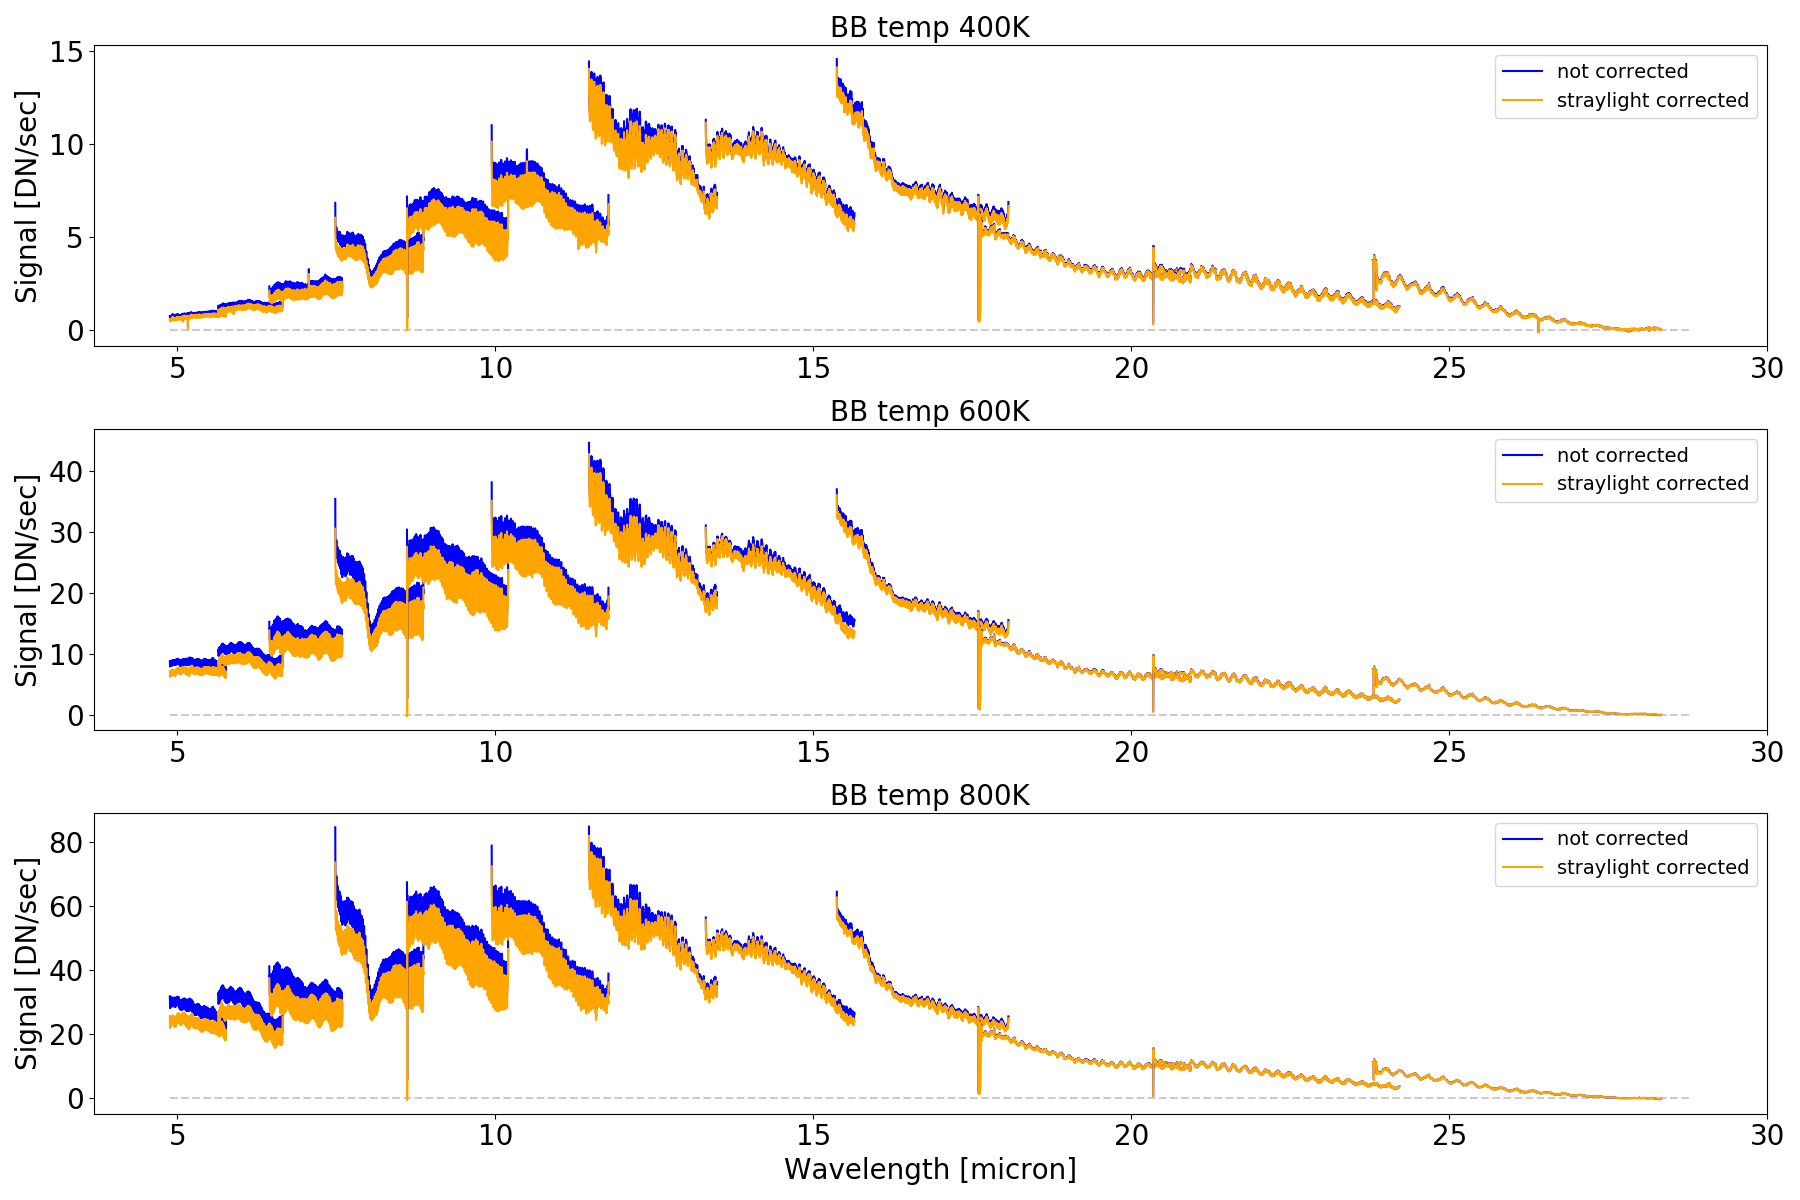

In [7]:
fig,axs = plt.subplots(3,1,figsize=(18,12))
plot = -1
for BBTemp in ["400K","600K", "800K"]:
    plot +=1
    for band in ["1A", "1B", "1C", "2A", "2B", "2C", "3A", "3B", "3C", "4A", "4B", "4C"]:
        d2cMaps   = funcs.load_obj('d2cMaps_band{}'.format(band),path=d2cMapDir)
        ypos,xpos = funcs.detpixel_trace(band=band,d2cMaps=d2cMaps,sliceID=d2cMaps['nslices']/2,alpha_pos=0)
        axs[plot].plot(lambdaMap[band][ypos,xpos],S_pixMap[BBTemp][band][ypos,xpos],'b')
        axs[plot].plot(lambdaMap[band][ypos,xpos],S_pixMap_STRCORR[BBTemp][band][ypos,xpos],'orange')
    axs[plot].hlines(0,4.88,28.8,'gray',alpha=0.4,linestyle='dashed')
    legend_elements = [Line2D([0],[0],color='b',label='not corrected'),Line2D([0],[0],color='orange',label='straylight corrected')]
    axs[plot].legend(handles=legend_elements)
    axs[plot].set_title("BB temp {}".format(BBTemp))
    axs[plot].set_ylabel('Signal [DN/sec]')
axs[2].set_xlabel('Wavelength [micron]')
plt.tight_layout()

## Remarks:
* The effect of the straylight correction step diminishes from the lowest to the highest wavelengths.  
  
Let's plot the ratio of the above spectra.

<IPython.core.display.Javascript object>


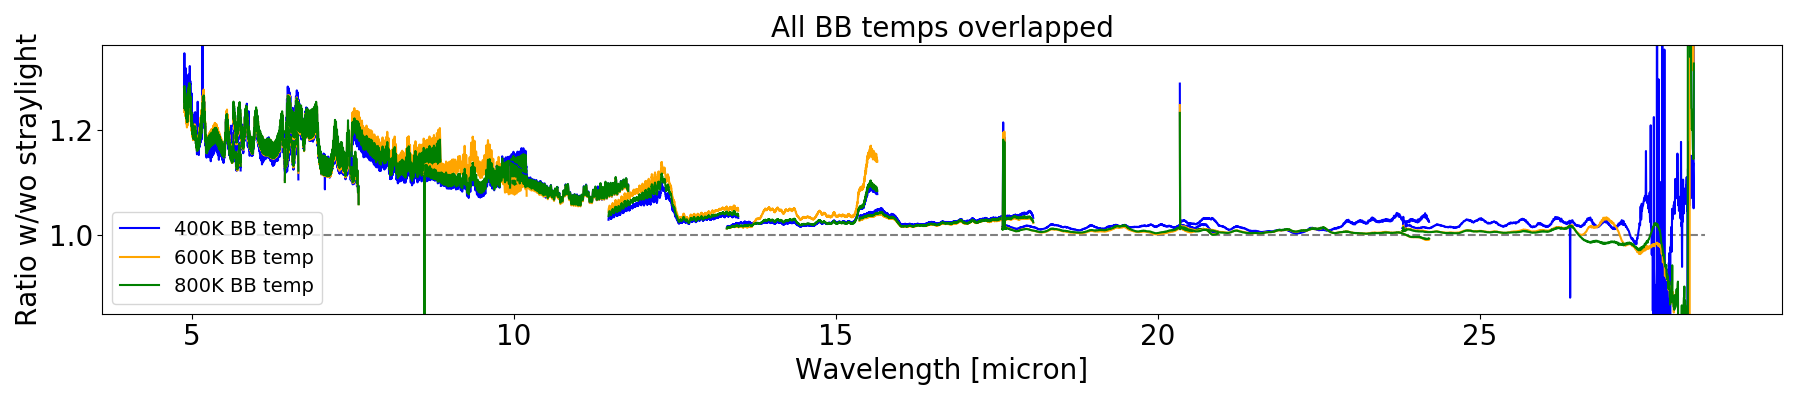

<IPython.core.display.Javascript object>


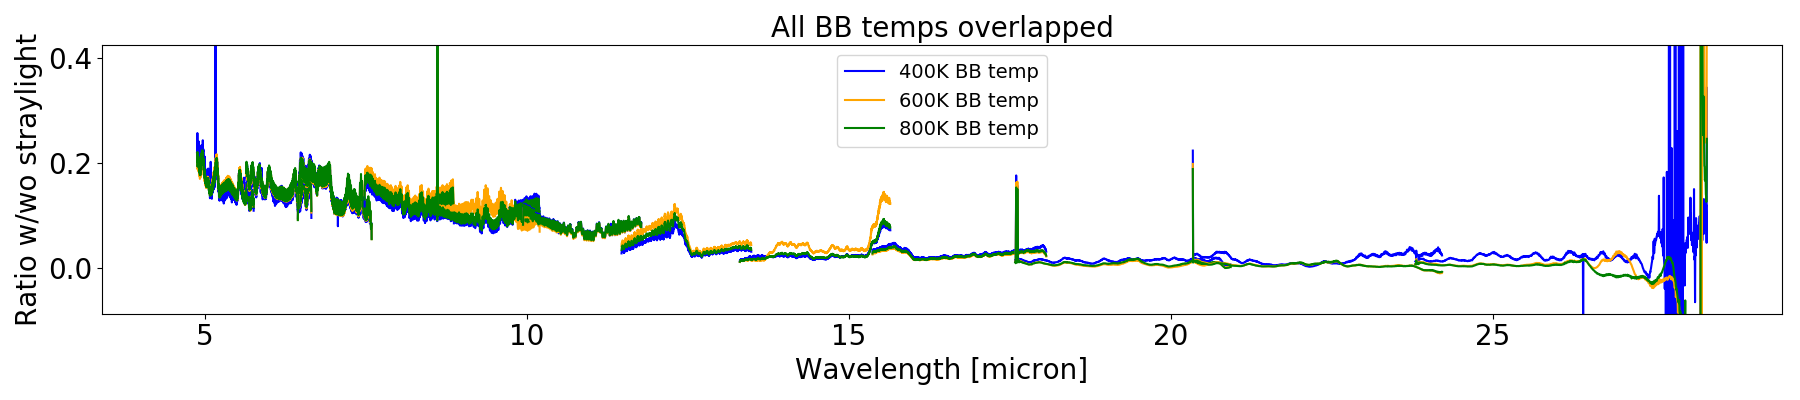

In [19]:
# fig,axs = plt.subplots(3,1,figsize=(18,12))
# plot = -1
# for BBTemp in ["400K","600K", "800K"]:
#     plot +=1
#     for band in ["1A", "1B", "1C", "2A", "2B", "2C", "3A", "3B", "3C", "4A", "4B", "4C"]:
#         d2cMaps   = funcs.load_obj('d2cMaps_band{}'.format(band),path=d2cMapDir)
#         ypos,xpos = funcs.detpixel_trace(band=band,d2cMaps=d2cMaps,sliceID=d2cMaps['nslices']/2,alpha_pos=0)
#         axs[plot].plot(lambdaMap[band][ypos,xpos],S_pixMap[BBTemp][band][ypos,xpos]/S_pixMap_STRCORR[BBTemp][band][ypos,xpos],'b')
#     axs[plot].hlines(1,4.8,28.5,'gray',linestyle='dashed')
#     axs[plot].set_ylim(0.6,1.5)
#     axs[plot].set_title("BB temp {}".format(BBTemp))
#     axs[plot].set_ylabel('Ratio w/wo straylight')
# axs[2].set_xlabel('Wavelength [micron]')
# plt.tight_layout()

plt.figure(figsize=(18,4))
for band in ["1A", "1B", "1C", "2A", "2B", "2C", "3A", "3B", "3C", "4A", "4B", "4C"]:
    d2cMaps   = funcs.load_obj('d2cMaps_band{}'.format(band),path=d2cMapDir)
    ypos,xpos = funcs.detpixel_trace(band=band,d2cMaps=d2cMaps,sliceID=d2cMaps['nslices']/2,alpha_pos=0)
    plt.plot(lambdaMap[band][ypos,xpos],S_pixMap['400K'][band][ypos,xpos]/S_pixMap_STRCORR['400K'][band][ypos,xpos],'b')
    plt.plot(lambdaMap[band][ypos,xpos],S_pixMap['600K'][band][ypos,xpos]/S_pixMap_STRCORR['600K'][band][ypos,xpos],'orange')
    plt.plot(lambdaMap[band][ypos,xpos],S_pixMap['800K'][band][ypos,xpos]/S_pixMap_STRCORR['800K'][band][ypos,xpos],'g')
plt.hlines(1,4.8,28.5,'gray',linestyle='dashed')
legend_elements = [Line2D([0],[0],color='b',label='400K BB temp'),Line2D([0],[0],color='orange',label='600K BB temp'),Line2D([0],[0],color='g',label='800K BB temp')]
plt.legend(handles=legend_elements)
plt.ylim(0.85,1.36)
plt.title('All BB temps overlapped')
plt.xlabel('Wavelength [micron]')
plt.ylabel('Ratio w/wo straylight')
plt.tight_layout()

## Remarks:
* The amount of straylight seems to decrease monotonically with wavelength. Is this expected? Shouldn't the amount of straylight be correlated to the absolute signal level rather than wavelength?
* The ratio of the MRS spectrum with and without straylight (straylight-subtracted) is similar for the three BB temperatures, despite the (very?) different absolute signal levels. Admittedly one would perhaps be inclined to say that the ratio follows the contribution of an undefined blackbody curve.
* The behavior of the ratio within one MRS spectral band seems to be erratic. This behavior has already been examined, and determined to be related to the definition of the detector2cube slice map (see html file "1 - Effect of straylight subtraction on MRS extended source observations" in https://github.com/YannisArgyriou/MRS_StraylightCorrection.git ).
* The ratio of the MRS spectrum with and without straylight yields a high-frequency fringe residual up to and including band 3A (13.5um). This implies that the straylight correction changes the phase/amplitude of the intrinsic spectrum high-frequency fringe ever so slightly. This has important ramifications for the derivation of an MRS fringe correction.
* Something peculiar is happening at 12.3um and at 15.5um (steep drop and steep rise in ratio respectively).
* The signal of the 400K BB spectrum appears to "pick up" between 22.5um and 26um. This is not the case for the 600K BB or the 800K BB spectrum. 
  
The MRS response is determined by taking the ratio of the science signal (S_pixMap) and the spectral irradiance (E_pixMap) of the respective BB observations. A fringe correction is also applied, however this one is the same for all three cases studied here. The MRS response is given in [$DN/sec/mJy/pixel$].

In [ ]:
# Populate dictionaries with maps of R_pix [DN/sec/mJy/pixel] and dR_pix 
# 
        
R_pixMap,R_pixMap_STRCORR = {},{}
dR_pixMap = {}

for BBTemp in ["400K","600K", "800K"]:
    print "BBTemp {}".format(BBTemp)
    R_pixMap[BBTemp] = {}
    R_pixMap_STRCORR[BBTemp] = {}
    dR_pixMap[BBTemp] = {}
    for band in ["1A", "1B", "1C", "2A", "2B", "2C", "3A", "3B", "3C", "4A", "4B", "4C"]:
        fringe_img = funcs.get_cdps(band,cdpDir)[0]
        R_pixMap[BBTemp][band] = np.full( validMap[band].shape, np.nan )
        R_pixMap_STRCORR[BBTemp][band] = np.full( validMap[band].shape, np.nan )
        dR_pixMap[BBTemp][band] = np.full( validMap[band].shape, np.nan )
        sel = (validMap[band]==1)& (BadPixelMap[BBTemp][band]==0)
        R_pixMap[BBTemp][band][sel] = (S_pixMap[BBTemp][band][sel] / E_pixMap[BBTemp][band][sel])/fringe_img[sel]
        R_pixMap_STRCORR[BBTemp][band][sel] = (S_pixMap_STRCORR[BBTemp][band][sel] / E_pixMap[BBTemp][band][sel])/fringe_img[sel]
        dR_pixMap[BBTemp][band][sel] = R_pixMap[BBTemp][band][sel] * dS_pixMap[BBTemp][band][sel]/S_pixMap[BBTemp][band][sel]
# save outputs
funcs.save_obj(R_pixMap,'R_pixMap',path='')
funcs.save_obj(R_pixMap_STRCORR,'R_pixMap_STRCORR',path='')

<IPython.core.display.Javascript object>


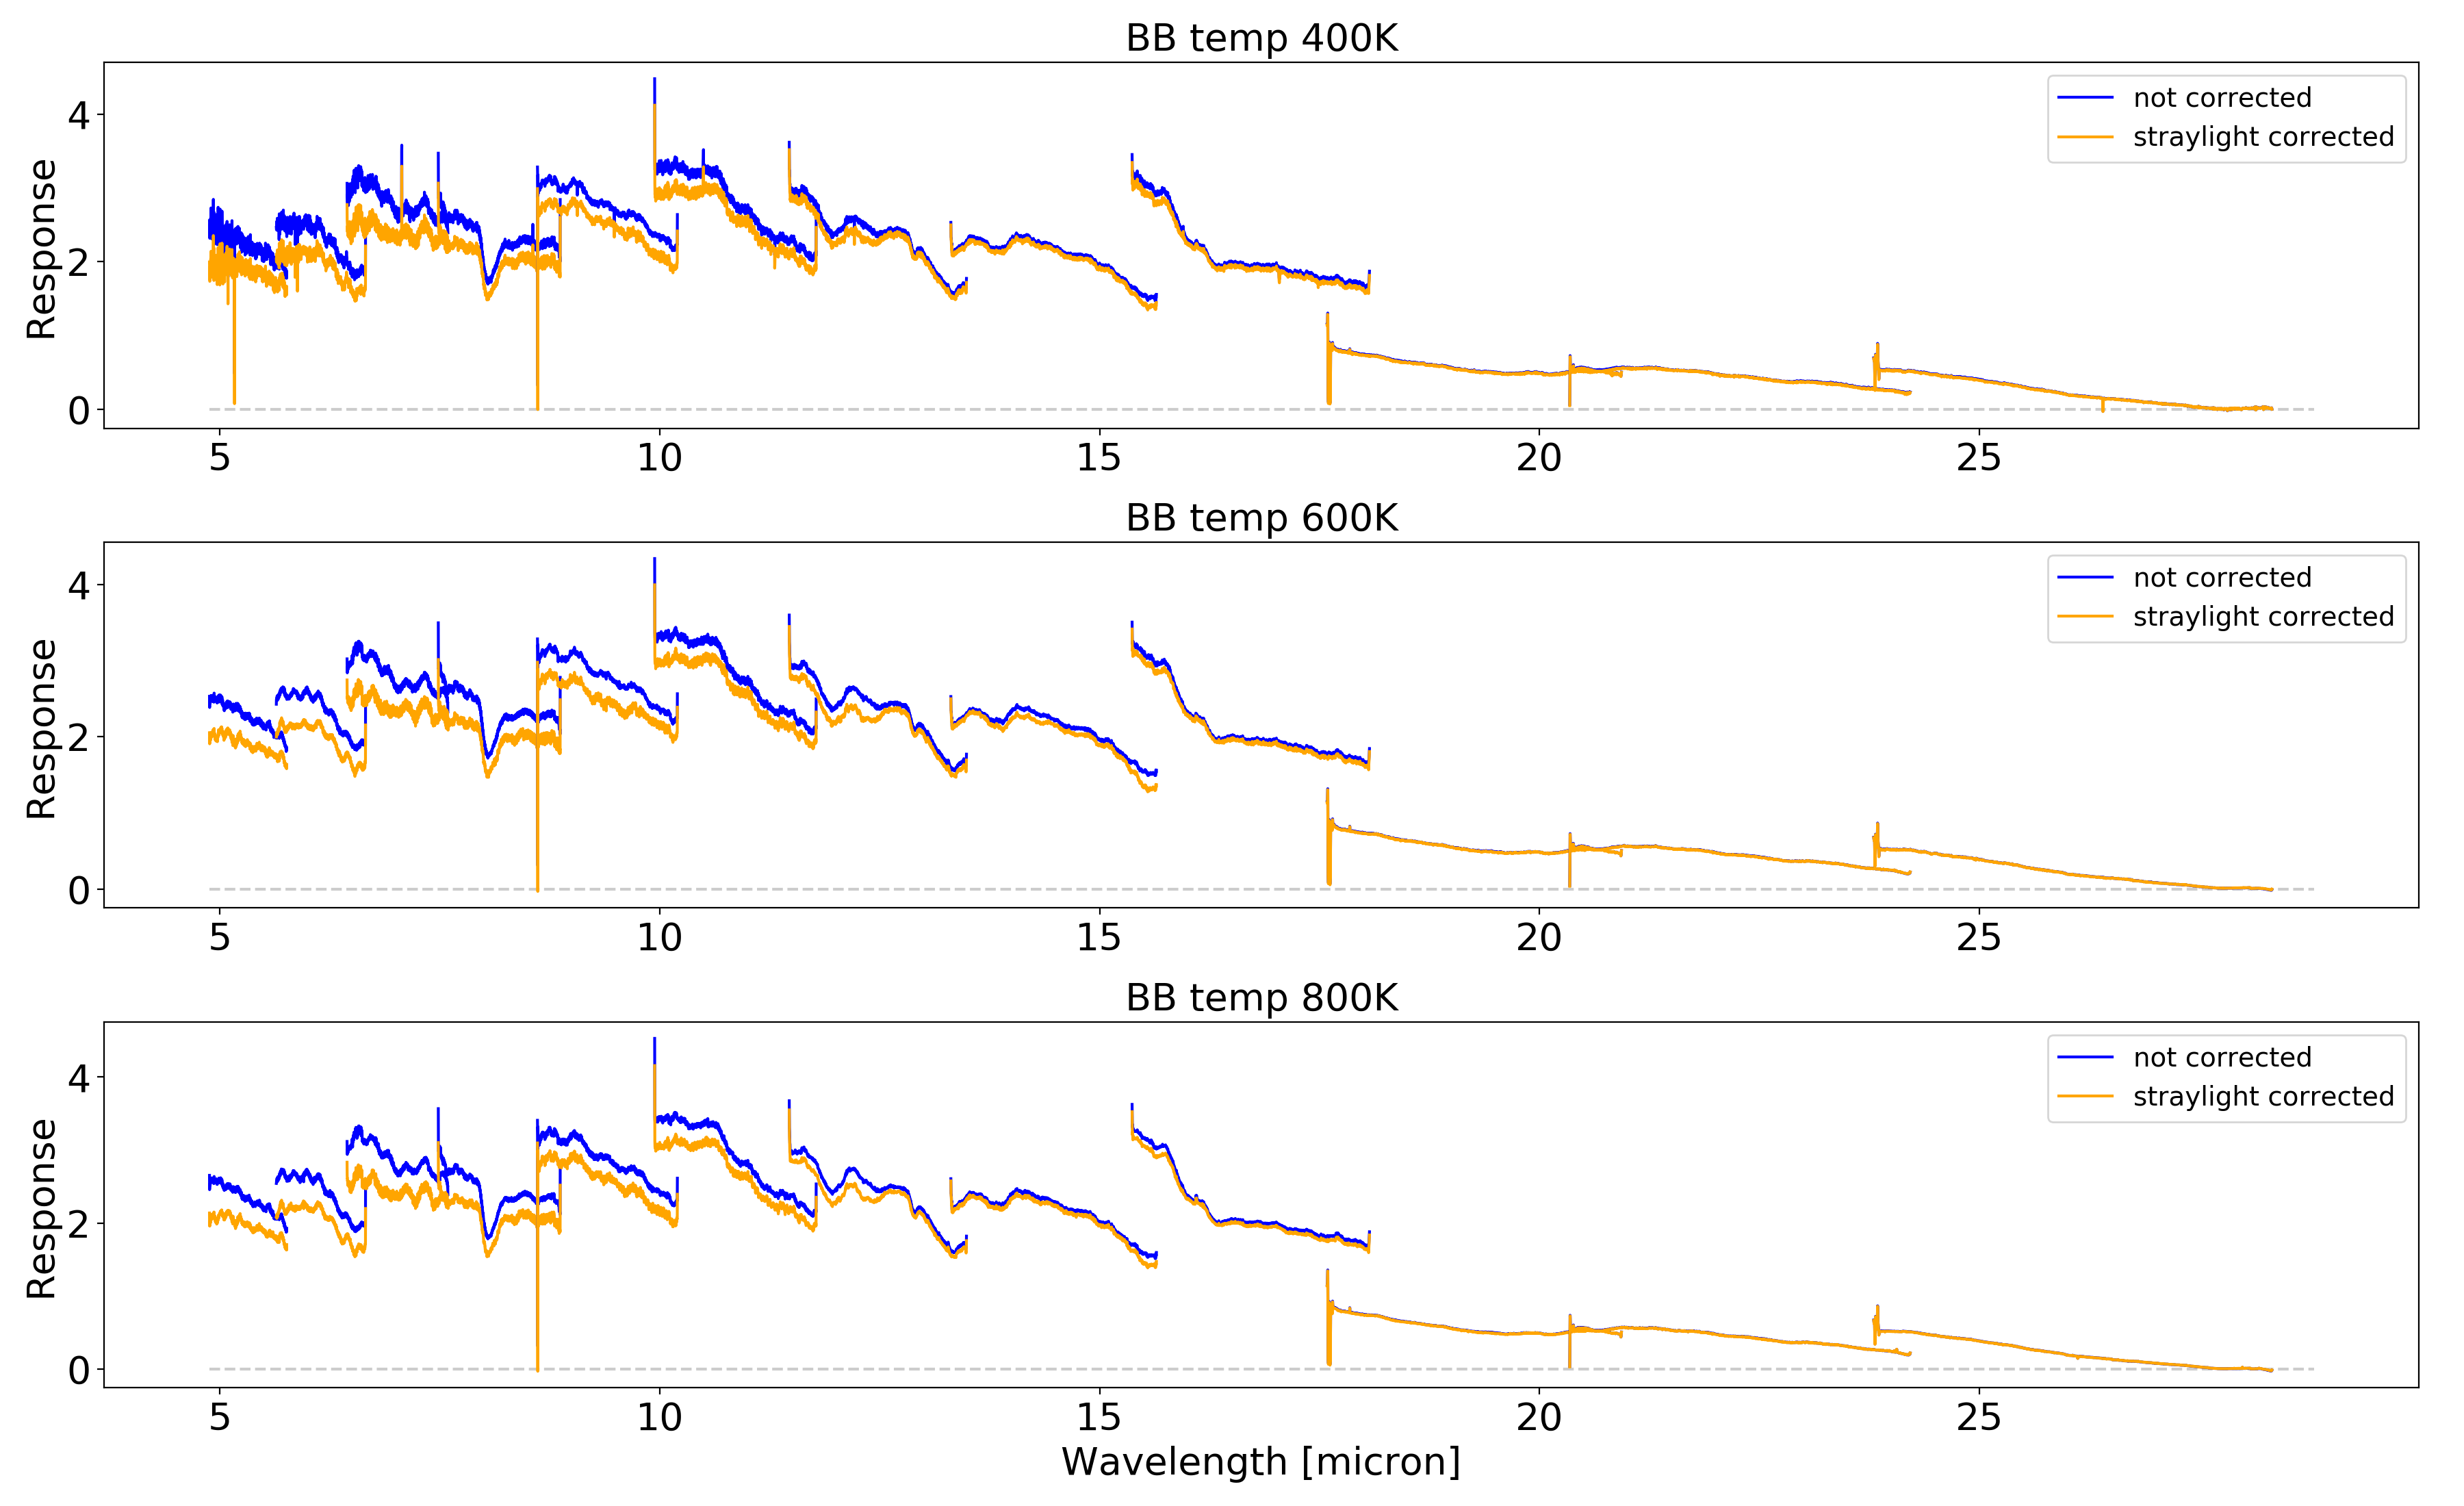

<IPython.core.display.Javascript object>


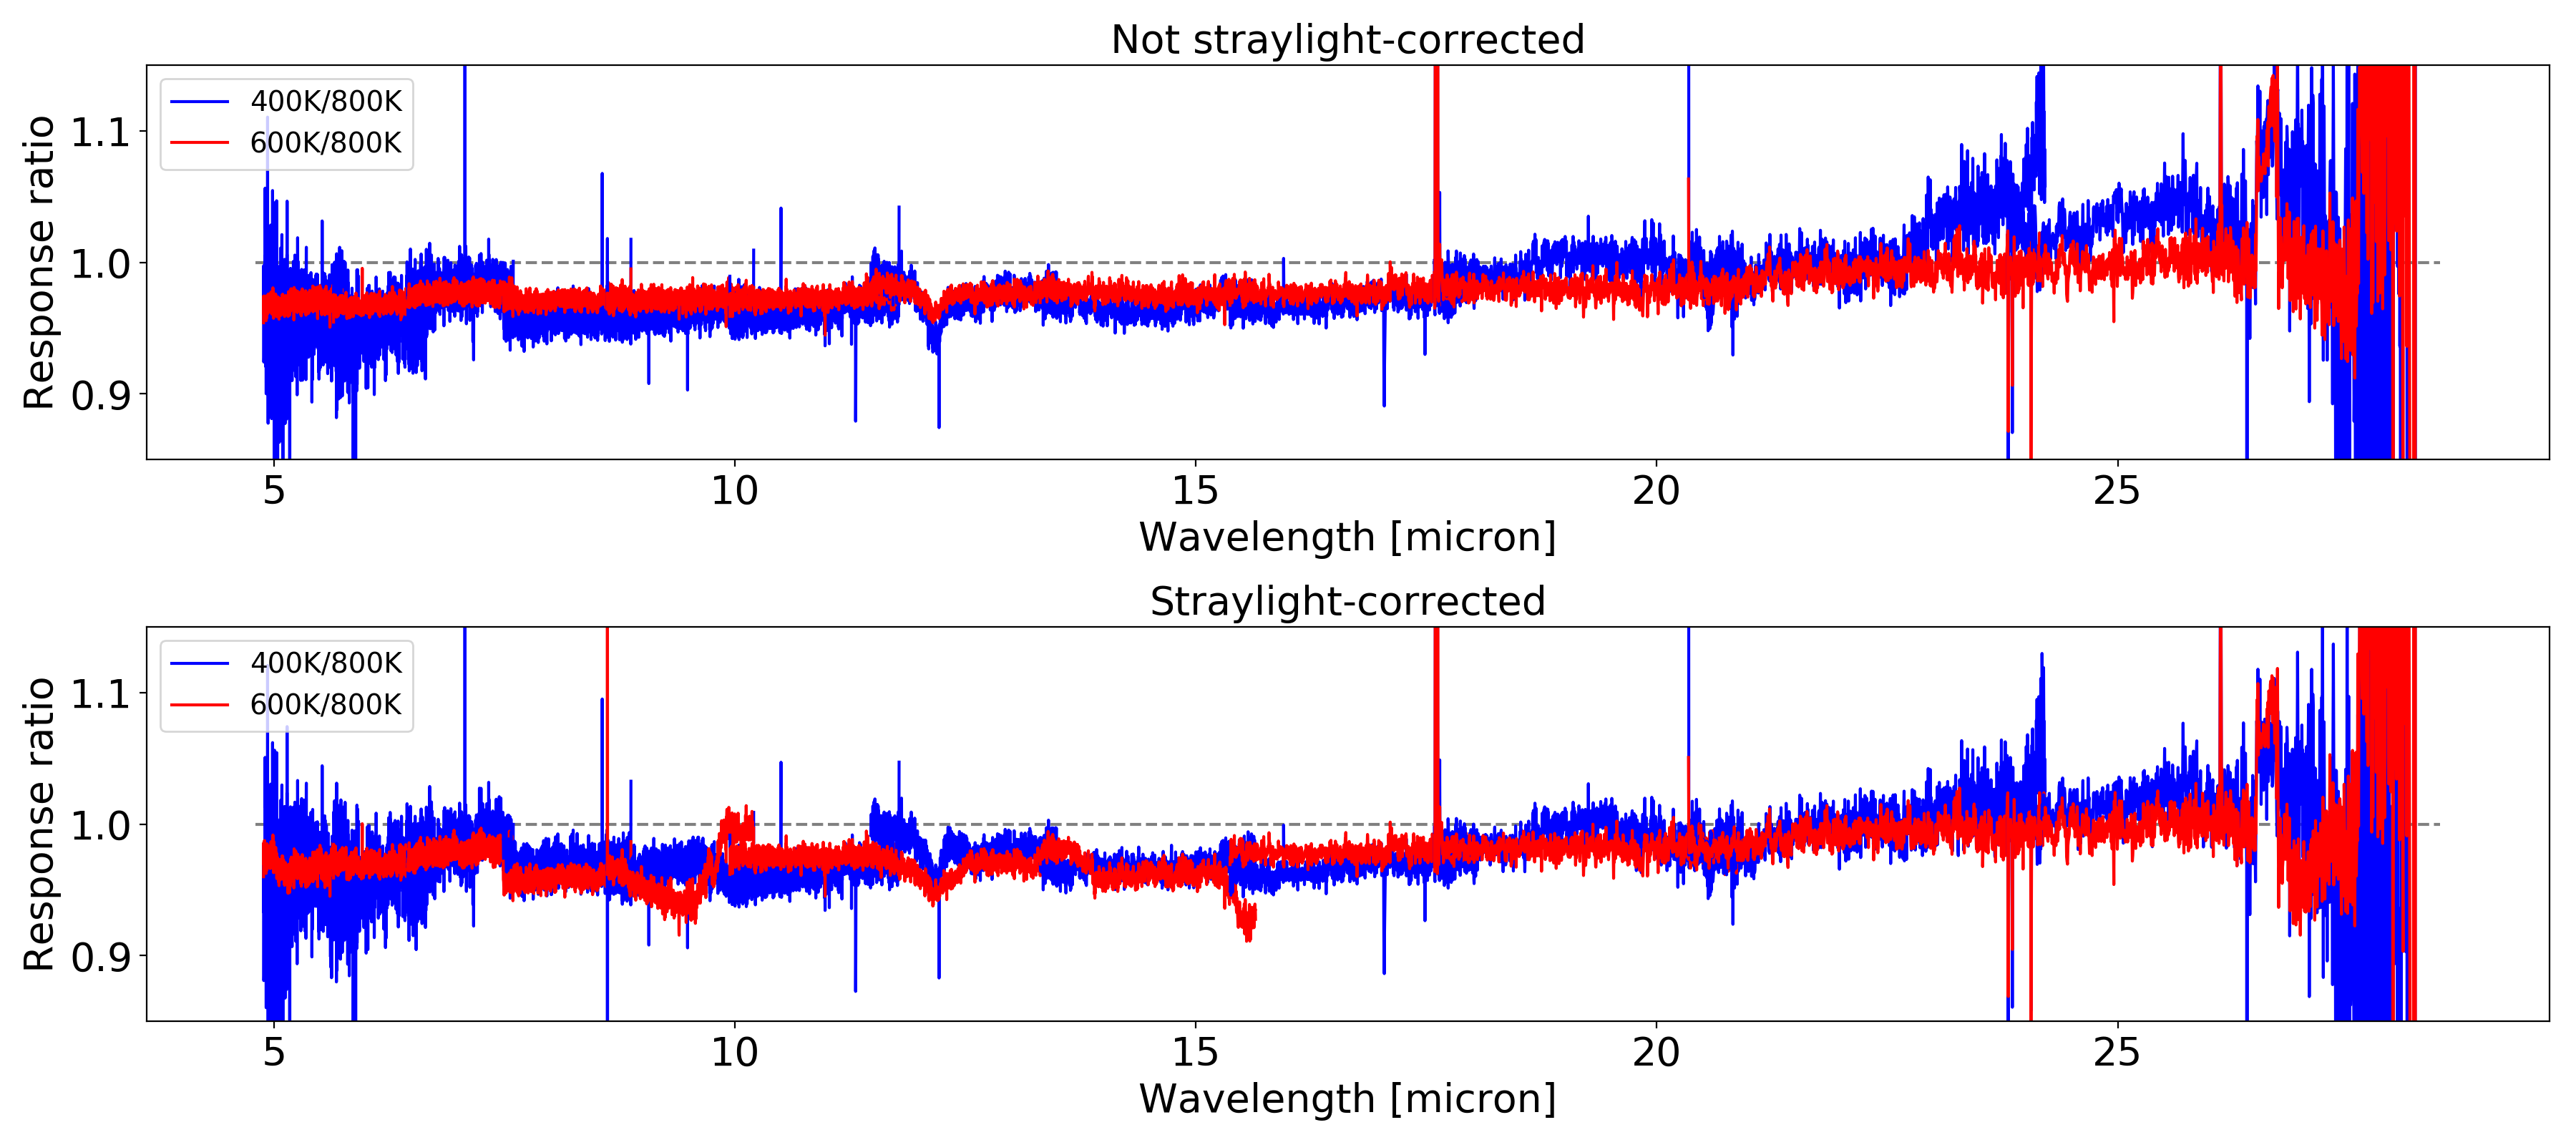

In [11]:
fig,axs = plt.subplots(3,1,figsize=(18,11))
plot = -1
for BBTemp in ["400K","600K", "800K"]:
    plot +=1
    for band in ["1A", "1B", "1C", "2A", "2B", "2C", "3A", "3B", "3C", "4A", "4B", "4C"]:
        d2cMaps   = funcs.load_obj('d2cMaps_band{}'.format(band),path=d2cMapDir)
        ypos,xpos = funcs.detpixel_trace(band=band,d2cMaps=d2cMaps,sliceID=d2cMaps['nslices']/2,alpha_pos=0)
        axs[plot].plot(lambdaMap[band][ypos,xpos],R_pixMap[BBTemp][band][ypos,xpos],'b')
        axs[plot].plot(lambdaMap[band][ypos,xpos],R_pixMap_STRCORR[BBTemp][band][ypos,xpos],'orange')
    axs[plot].hlines(0,4.88,28.8,'gray',alpha=0.4,linestyle='dashed')
    legend_elements = [Line2D([0],[0],color='b',label='not corrected'),Line2D([0],[0],color='orange',label='straylight corrected')]
    axs[plot].legend(handles=legend_elements)
    axs[plot].set_title("BB temp {}".format(BBTemp))
    axs[plot].set_ylabel('Response') # [DN sec^-1 mJy^-1 pixel]
axs[2].set_xlabel('Wavelength [micron]')
plt.tight_layout()

fig,axs = plt.subplots(2,1,figsize=(18,8))
axs[0].set_title('Not straylight-corrected')
axs[1].set_title('Straylight-corrected')
for band in ["1A", "1B", "1C", "2A", "2B", "2C", "3A", "3B", "3C", "4A", "4B", "4C"]:
    d2cMaps   = funcs.load_obj('d2cMaps_band{}'.format(band),path=d2cMapDir)
    ypos,xpos = funcs.detpixel_trace(band=band,d2cMaps=d2cMaps,sliceID=d2cMaps['nslices']/2,alpha_pos=0)
    axs[0].plot(lambdaMap[band][ypos,xpos],R_pixMap['400K'][band][ypos,xpos]/R_pixMap['800K'][band][ypos,xpos],'b')
    axs[0].plot(lambdaMap[band][ypos,xpos],R_pixMap['600K'][band][ypos,xpos]/R_pixMap['800K'][band][ypos,xpos],'r')
    
    axs[1].plot(lambdaMap[band][ypos,xpos],R_pixMap_STRCORR['400K'][band][ypos,xpos]/R_pixMap_STRCORR['800K'][band][ypos,xpos],'b')
    axs[1].plot(lambdaMap[band][ypos,xpos],R_pixMap_STRCORR['600K'][band][ypos,xpos]/R_pixMap_STRCORR['800K'][band][ypos,xpos],'r')
legend_elements = [Line2D([0],[0],color='b',label='400K/800K'),Line2D([0],[0],color='r',label='600K/800K')]
for plot in range(2):
    axs[plot].set_ylim(0.85,1.15)
    axs[plot].hlines(1,4.8,28.5,'gray',linestyle='dashed')
    axs[plot].legend(handles=legend_elements)
    axs[plot].set_xlabel('Wavelength [micron]')
    axs[plot].set_ylabel('Response ratio')
plt.tight_layout()

## Remarks:
* Subtracting the straylight yields a lower response.
* We previously determined that applying the straylight correction yields a similar signal correction factor for all three BB temperatures. As such the comparison between the responses of 400K/800K and 600K/800K, in the case with and without the straylight correction applied, look very similar.
* The straylight-corrected response ratio plot displays a more erratic behavior compared to the not straylight corrected plot. This result puts the calibration step into question from the point of view of the MRS response derivation, and whether the former should be applied in the process of the latter.

# Conclusions
* The straylight signal determined for different blackbody source temperatures appears to vary with wavelength rather than with absolute intensity.
* The ratio of straylight signal w.r.t. the scientific signal is the same for all three blackbody temperatures (despite the different absolute signal levels).
* The ratio of the MRS spectrum with and without straylight yields a high-frequency fringe residual up to and including band 3A (13.5um). This implies that the straylight correction changes the phase/amplitude of the intrinsic spectrum high-frequency fringe ever so slightly (important in the context of deriving an accurate fringe correction).
* Applying straylight correction effective lowers the derived MRS response. 
* The change in the ratio of responses between different BB source temperatures (for the case with and without straylight) is very small. Correcting for straylight introduces some erratic jumps in the ratio, which negatively impact the consistency between the 400K/800K response ratio and the 600K/800K response ratio.

# Follow-up question:
* How does the derived response affect the internal calibration source spectrum?